In [39]:
#Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose




In [40]:
#Settings
TRAIN_SZ = 0.7
VAL_SZ = 0.15
TEST_SZ = 0.15
FOLD_SZ = 4
LAGS_SZ = 8
H_FORECAST = 1
L_RATE = 0.005

In [41]:
#Consumption dataframe
df_consumo = pd.read_csv(r"consumo_energia.csv")
df_consumo['date'] = pd.to_datetime(df_consumo['din_instante'])
df_consumo.set_index('date', inplace=True)
df_consumo.sort_index(inplace=True)
df_consumo.drop(['id_subsistema'],axis=1)

#Generation dataframe
df_geracao = pd.read_csv(r"geracao_energia.csv")
df_geracao['date'] = pd.to_datetime(df_geracao['index'])
df_geracao.set_index('date', inplace=True)
df_geracao['month'] = df_geracao.index.month
df_geracao['weekday'] = df_geracao.index.weekday
df_geracao.sort_index(inplace=True)

merged_df = pd.merge(df_geracao, df_consumo, on='date')
result = seasonal_decompose(merged_df['val_geracao'], model='additive', period=48)

merged_df['seasonal'] = result.seasonal
merged_df

,index,val_geracao,id_subsistema_x,nom_subsistema_x,id_estado,cod_modalidadeoperacao,id_ons,nom_tipousina,month,weekday,din_instante,id_subsistema_y,nom_subsistema_y,din_instante.1,val_cargaenergiamwmed,seasonal
date,,,,,,,,,,,,,,,,
2020-01-01,2020-01-01,116387.442,S,SUL,PR,TIPO I,PRGJR,HIDROELÉTRICA,1,2,2020-01-01,S,Sul,2020-01-01,9969.994875,12505.942554
2020-01-02,2020-01-02,163275.410,S,SUL,PR,TIPO I,PRUHSS,HIDROELÉTRICA,1,3,2020-01-02,S,Sul,2020-01-02,11190.429417,7387.359871
2020-01-03,2020-01-03,147938.013,S,SUL,PR,TIPO I,PRSCL,HIDROELÉTRICA,1,4,2020-01-03,S,Sul,2020-01-03,11121.447042,-119.937208
2020-01-04,2020-01-04,138267.427,S,SUL,PR,TIPO I,PRSCL,HIDROELÉTRICA,1,5,2020-01-04,S,Sul,2020-01-04,10443.865958,-1427.387461
2020-01-05,2020-01-05,116522.452,S,SUL,PR,TIPO I,PRGNB,HIDROELÉTRICA,1,6,2020-01-05,S,Sul,2020-01-05,9790.935042,-2793.872876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,2024-12-27,283163.017,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,4,2024-12-27,S,Sul,2024-12-27,12800.938792,2503.603589
2024-12-28,2024-12-28,268000.832,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,5,2024-12-28,S,Sul,2024-12-28,12649.711875,6634.978005
2024-12-29,2024-12-29,269194.124,S,SUL,PR,Pequenas Usinas (Tipo III),PQU_PRPR_E,EOLIELÉTRICA,12,6,2024-12-29,S,Sul,2024-12-29,11543.374792,12505.942554


In [42]:
#Data Preprocessing
df = merged_df

# Seleção de colunas e normalização
df = df[['index', 'month', 'weekday', 'val_geracao', 'val_cargaenergiamwmed','seasonal']]

#Divind Train and Test, the cross validation will be applied to the train set
train_set = df[:1516]
test_set = df[1516:] # will be used at the end of each model training and at the end for the meta model validation

In [43]:
#Z-Score Standarization
scaler = StandardScaler()
train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
train_set['month_norm'] = scaler.fit_transform(train_set[['month']])
train_set['weekday_norm'] = scaler.fit_transform(train_set[['weekday']])
train_set['seasonal_norm'] = scaler.fit_transform(train_set[['seasonal']])

#defininf dependent and idependent variables
predictors = train_set[['month_norm','weekday_norm','val_geracao_norm','val_cargaenergiamwmed_norm','seasonal_norm']]
predicted = predictors[['val_geracao_norm']]


#Creating sequences
X, y = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X.append(data_np[i:i+LAGS_SZ])
    y.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X = np.array(X)
y = np.array(y)
# KFold sobre os dados de treino/validação
kf = KFold(n_splits=FOLD_SZ, shuffle=False)

X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

for train_index, test_index in kf.split(X):
    X_train_fold = X[train_index]
    X_test_fold = X[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]

    X_train_folds.append(X_train_fold)
    X_test_folds.append(X_test_fold)
    y_train_folds.append(y_train_fold)
    y_test_folds.append(y_test_fold)

C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\3209409124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\3209409124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\3209409124.py:5: SettingWithCopyWarning: 
A value is tryi

In [44]:
#Models definition

#Buildintg the LSTM architecture
def build_lstm(input_shape, learning_rate):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model
    
#Buildintg the GRU architecture
def build_gru(input_shape, learning_rate):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

#Buildintg the XGBoost architecture
def build_xgboost():
    model = xgb.XGBRegressor(objective='reg:squarederror',
                             colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.005, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             verbosity=1,
                             random_state =7, 
                             nthread = -1)
    return model

#Building a CNN architecture
def build_cnn(input_shape, learning_rate):
    model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

# ------------------------ Meta Learner ----------------------- #

def build_rf():
    return LinearSVR()


In [45]:
#list of models
xgb_trained  = []
cnn_trained  = []
gru_trained  = []
lstm_trained = []

# Prediction that are composing the meta learner training set
xgb_preds  = []
cnn_preds  = []
gru_preds  = []
lstm_preds = []

In [46]:
#Eval function
def print_metrics(y_true, y_pred, model_name, fold):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'\n📊 Fold {fold} - {model_name}:\n'
          f'   MSE:  {mse:.4f}\n'
          f'   RMSE: {rmse:.4f}\n'
          f'   MAPE: {mape:.4f}\n')

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


fold X 1 de treino: (1131, 8, 5) e fold 1 X de teste: (377, 8, 5)
fold y 1 de treino: (1131, 1, 1) e fold 1 y de teste: (377, 1, 1)
 -------------------------------------- Treinando o fold 1 da rede LSTM -------------------------------------- 
Epoch 1/50
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3193 - root_mean_squared_error: 0.5533
Epoch 1: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3066 - root_mean_squared_error: 0.5420
Epoch 2/50
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1339 - root_mean_squared_error: 0.3659
Epoch 2: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1320 - root_mean_squared_error: 0.3632
Epoch 3/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1110 - root_mean_squared_error: 0.3329
Epoch 3: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1082 - root_mean_squared_error: 0.3287
Epoch 4/50
25/36 ━━━━━━━━━━━━━

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4971 - root_mean_squared_error: 0.6931   
Epoch 1: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3938 - root_mean_squared_error: 0.6142
Epoch 2/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1293 - root_mean_squared_error: 0.3594 
Epoch 2: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1270 - root_mean_squared_error: 0.3562
Epoch 3/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1162 - root_mean_squared_error: 0.3407 
Epoch 3: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1138 - root_mean_squared_error: 0.3373
Epoch 4/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0968 - root_mean_squared_error: 0.3110 
Epoch 4: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0963 - root_mean_squared_error: 0.3103
Epoch 5/50
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5552 - root_mean_squared_error: 0.7221
Epoch 1: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5109 - root_mean_squared_error: 0.6910
Epoch 2/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1194 - root_mean_squared_error: 0.3453
Epoch 2: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1192 - root_mean_squared_error: 0.3450
Epoch 3/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1172 - root_mean_squared_error: 0.3421
Epoch 3: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1152 - root_mean_squared_error: 0.3391
Epoch 4/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1038 - root_mean_squared_error: 0.3220
Epoch 4: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1009 - root_mean_squared_error: 0.3173
Epoch 5/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8114 - root_mean_squared_error: 0.8802   
Epoch 1: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6174 - root_mean_squared_error: 0.7598
Epoch 2/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1172 - root_mean_squared_error: 0.3422
Epoch 2: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1171 - root_mean_squared_error: 0.3420
Epoch 3/50
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0978 - root_mean_squared_error: 0.3127 
Epoch 3: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0957 - root_mean_squared_error: 0.3094
Epoch 4/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936 - root_mean_squared_error: 0.3059 
Epoch 4: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0944 - root_mean_squared_error: 0.3073
Epoch 5/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4127 - root_mean_squared_error: 0.6319
Epoch 1: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3806 - root_mean_squared_error: 0.6065
Epoch 2/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1387 - root_mean_squared_error: 0.3723
Epoch 2: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1378 - root_mean_squared_error: 0.3710
Epoch 3/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1148 - root_mean_squared_error: 0.3387
Epoch 3: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1134 - root_mean_squared_error: 0.3366
Epoch 4/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0920 - root_mean_squared_error: 0.3028
Epoch 4: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0905 - root_mean_squared_error: 0.3003
Epoch 5/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6366 - root_mean_squared_error: 0.7770   
Epoch 1: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4911 - root_mean_squared_error: 0.6777
Epoch 2/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1149 - root_mean_squared_error: 0.3387 
Epoch 2: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1164 - root_mean_squared_error: 0.3410
Epoch 3/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1063 - root_mean_squared_error: 0.3260 
Epoch 3: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1069 - root_mean_squared_error: 0.3268
Epoch 4/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0993 - root_mean_squared_error: 0.3150 
Epoch 4: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0991 - root_mean_squared_error: 0.3147
Epoch 5/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3450 - root_mean_squared_error: 0.5784
Epoch 1: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3211 - root_mean_squared_error: 0.5575
Epoch 2/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1178 - root_mean_squared_error: 0.3431
Epoch 2: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1169 - root_mean_squared_error: 0.3418
Epoch 3/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1057 - root_mean_squared_error: 0.3249
Epoch 3: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1036 - root_mean_squared_error: 0.3217
Epoch 4/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0821 - root_mean_squared_error: 0.2861
Epoch 4: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0790 - root_mean_squared_error: 0.2807
Epoch 5/50
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5854 - root_mean_squared_error: 0.7504   
Epoch 1: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4332 - root_mean_squared_error: 0.6408
Epoch 2/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1249 - root_mean_squared_error: 0.3532 
Epoch 2: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1240 - root_mean_squared_error: 0.3520
Epoch 3/50
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1186 - root_mean_squared_error: 0.3443 
Epoch 3: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1134 - root_mean_squared_error: 0.3366
Epoch 4/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824 - root_mean_squared_error: 0.2870 
Epoch 4: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0852 - root_mean_squared_error: 0.2918
Epoch 5/50
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

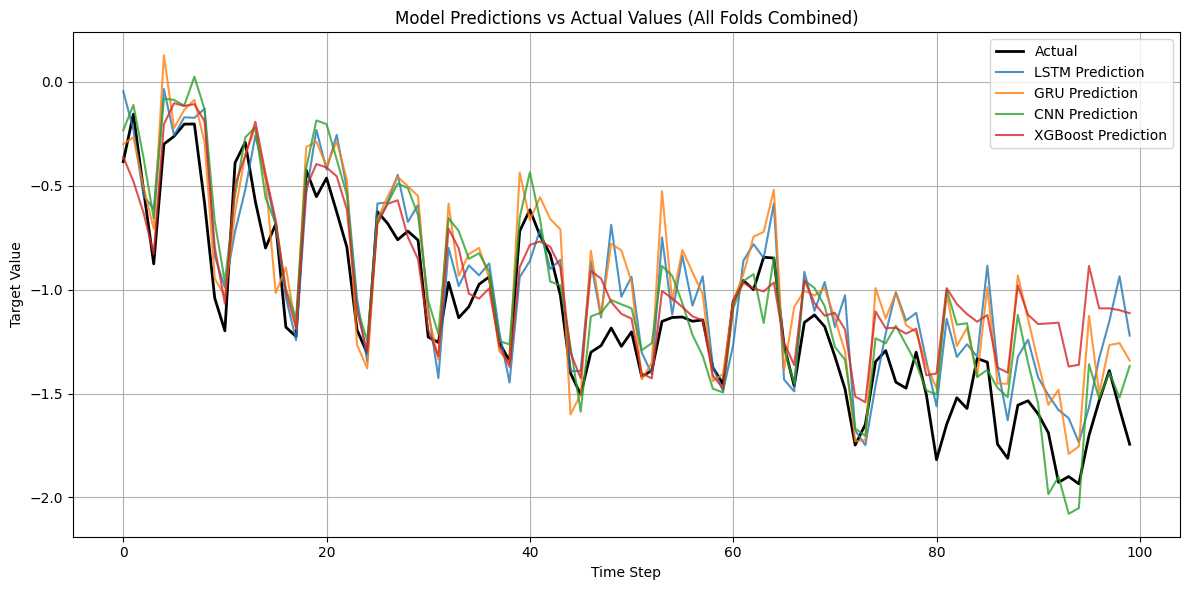

In [47]:
# CV loop for training
for i in range(FOLD_SZ):
    print(f'fold X {i+1} de treino: {X_train_folds[i].shape} e fold {i+1} X de teste: {X_test_folds[i].shape}')
    print(f'fold y {i+1} de treino: {y_train_folds[i].shape} e fold {i+1} y de teste: {y_test_folds[i].shape}')


    #Training the lstm net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede LSTM -------------------------------------- ')
    lstm = build_lstm(X_train_folds[i].shape[1:], L_RATE)
    checkpoint = ModelCheckpoint(f'models/lstm_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    lstm.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint)

    #Training the gru net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede GRU -------------------------------------- ')
    gru  = build_gru(  X_train_folds[i].shape[1:],L_RATE)
    checkpoint_gru = ModelCheckpoint(f'models/gru_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    gru.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_gru)

    #Training the cnn net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede CNN -------------------------------------- ')
    cnn  = build_cnn( X_train_folds[i].shape[1:],L_RATE)
    checkpoint_cnn = ModelCheckpoint(f'models/cnn_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    cnn.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_cnn)

    #Training the xgboost net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede XGB --------------------------------------')
    xgb_model = build_xgboost()  # renamed from xgb
    xgb_model.fit(
        X_train_folds[i].reshape(X_train_folds[i].shape[0], -1),
        y_train_folds[i].squeeze(),
        verbose=True
    )
    xgb_model.save_model(f'models/xbg_fold_{i+1}.json')

    #Saving the models
    lstm_trained.append(lstm)
    print(lstm_trained)

    gru_trained.append(gru)
    print(gru_trained)

    cnn_trained.append(cnn)
    print(cnn_trained)

    xgb_trained.append(xgb)
    print(xgb_trained)

    lstm_pred = lstm.predict(X_test_folds[i])
    gru_pred  = gru.predict(X_test_folds[i])
    cnn_pred  = cnn.predict(X_test_folds[i])
    xgb_pred  = xgb_model.predict(X_test_folds[i].reshape(X_test_folds[i].shape[0], -1))

    # Save predictions
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    cnn_preds.append(cnn_pred)
    xgb_preds.append(xgb_pred)

    # Calculate and print metrics
    y_true = y_test_folds[i].squeeze()
    print_metrics(y_true, lstm_pred.squeeze(), 'LSTM', i+1)
    print_metrics(y_true, gru_pred.squeeze(),  'GRU',  i+1)
    print_metrics(y_true, cnn_pred.squeeze(),  'CNN',  i+1)
    print_metrics(y_true, xgb_pred.squeeze(),  'XGBoost', i+1)

# Concatenate predictions and actual values from all folds
y_test_all = np.concatenate(y_test_folds).squeeze()
lstm_all   = np.concatenate(lstm_preds).squeeze()
gru_all    = np.concatenate(gru_preds).squeeze()
cnn_all    = np.concatenate(cnn_preds).squeeze()
xgb_all    = np.concatenate(xgb_preds).squeeze()

# Plot all predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_all[:100], label='Actual', color='black', linewidth=2)
plt.plot(lstm_all[:100], label='LSTM Prediction', alpha=0.8)
plt.plot(gru_all[:100], label='GRU Prediction', alpha=0.8)
plt.plot(cnn_all[:100], label='CNN Prediction', alpha=0.8)
plt.plot(xgb_all[:100], label='XGBoost Prediction', alpha=0.8)

plt.title('Model Predictions vs Actual Values (All Folds Combined)')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
#training Meta Model
df_meta_model = pd.DataFrame({
    'xgb': xgb_all,
    'cnn': cnn_all,
    'gru': gru_all,
    'lstm': lstm_all,
    'actual':y_test_all
})

train = df_meta_model

predictors = train[['xgb','cnn','gru','lstm','actual']]
predicted = train[['actual']]

X_train, y_train = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_train.append(data_np[i:i+LAGS_SZ])
    y_train.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_flat = y_train.reshape(y_train.shape[0], -1)

rf = build_rf()
rf.fit(X_train_flat, y_train_flat.ravel()) 

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [49]:
#preprocess test data
scalers = {}
#Z-Score Standarization
for col in ['val_geracao', 'val_cargaenergiamwmed', 'month', 'weekday', 'seasonal']:
    scalers[col] = StandardScaler()
    test_set[f'{col}_norm'] = scalers[col].fit_transform(test_set[[col]])

#defining dependent and idependent variables
test_predictors = test_set[['month_norm', 'weekday_norm', 'val_geracao_norm', 'val_cargaenergiamwmed_norm','seasonal_norm']]
test_predicted = test_predictors[['val_geracao_norm']]

#Creating Sequences
X_test_final, y_test_final = [], []
data_test_np = test_predictors.to_numpy()
pred_test_np = test_predicted.to_numpy()

for i in range(len(data_test_np) - LAGS_SZ - H_FORECAST + 1):
    X_test_final.append(data_test_np[i:i+LAGS_SZ])
    y_test_final.append(pred_test_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_test_final = np.array(X_test_final)
y_test_final = np.array(y_test_final)

# # Rebuild and load weights
# lstm = build_lstm(X_test_final.shape[1:], L_RATE)
# gru = build_gru(X_test_final.shape[1:], L_RATE)
# cnn = build_cnn(X_test_final.shape[1:], L_RATE)
# xgb_model = build_xgboost()

lstm.load_weights('models/lstm_fold_2.weights.h5')
gru.load_weights('models/gru_fold_2.weights.h5')
cnn.load_weights('models/cnn_fold_2.weights.h5')
xgb_model.load_model('models/xbg_fold_2.json')

# Predict
y_pred_lstm = lstm.predict(X_test_final)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))


def print_metrics(y_true, y_pred, model_name, fold=None):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)


    fold_info = f" | Fold {fold}" if fold is not None else ""
    print(f"{model_name}{fold_info} -> MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")

print_metrics(y_test_final, y_pred_lstm, 'LSTM')
print_metrics(y_test_final, y_pred_gru,  'GRU')
print_metrics(y_test_final, y_pred_cnn,  'CNN')
print_metrics(y_test_final, y_pred_xgb,  'XGBoost')

C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\1404009066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[f'{col}_norm'] = scalers[col].fit_transform(test_set[[col]])
C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\1404009066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[f'{col}_norm'] = scalers[col].fit_transform(test_set[[col]])
C:\Users\mateu\AppData\Local\Temp\ipykernel_4680\1404009066.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM -> MSE: 0.3635 | RMSE: 0.6029 | MAPE: 3.21%
GRU -> MSE: 0.3418 | RMSE: 0.5846 | MAPE: 3.56%
CNN -> MSE: 0.3847 | RMSE: 0.6203 | MAPE: 3.00%
XGBoost -> MSE: 0.3753 | RMSE: 0.6126 | MAPE: 2.67%


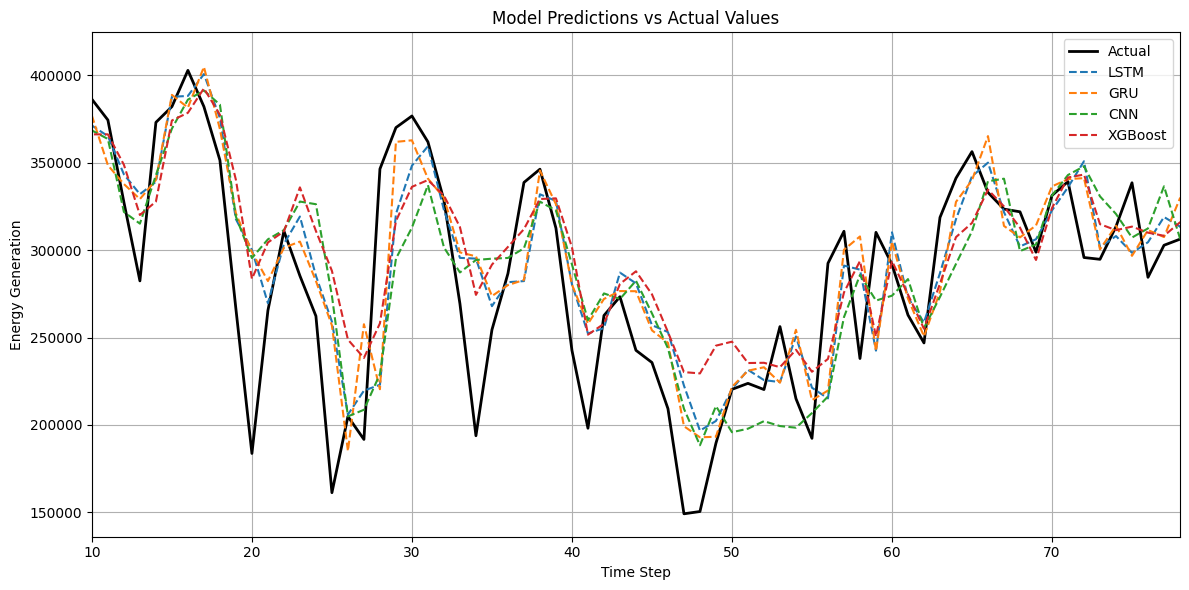

In [50]:
#Ploting data
y_true = y_test_final.reshape(-1)
y_lstm = y_pred_lstm.reshape(-1)
y_gru  = y_pred_gru.reshape(-1)
y_cnn  = y_pred_cnn.reshape(-1)
y_xgb  = y_pred_xgb.reshape(-1)

y_true_orig = scalers['val_geracao'].inverse_transform(y_true.reshape(-1, 1)).flatten()
y_lstm_orig = scalers['val_geracao'].inverse_transform(y_lstm.reshape(-1, 1)).flatten()
y_gru_orig  = scalers['val_geracao'].inverse_transform(y_gru.reshape(-1, 1)).flatten()
y_cnn_orig  = scalers['val_geracao'].inverse_transform(y_cnn.reshape(-1, 1)).flatten()
y_xgb_orig  = scalers['val_geracao'].inverse_transform(y_xgb.reshape(-1, 1)).flatten()



plt.figure(figsize=(12, 6))

plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)
plt.plot(y_lstm_orig, label='LSTM', linestyle='--')
plt.plot(y_gru_orig, label='GRU', linestyle='--')
plt.plot(y_cnn_orig, label='CNN', linestyle='--')
plt.plot(y_xgb_orig, label='XGBoost', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(10, 78)
plt.show()

In [51]:
#passing it to the SVR meta model
y_pred_lstm = lstm.predict(X_test_final)       # shape: (samples, steps)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))  # shape: (samples,)

# Flatten each prediction if needed
lstm_preds_flat = y_pred_lstm.reshape(-1)
gru_preds_flat  = y_pred_gru.reshape(-1)
cnn_preds_flat  = y_pred_cnn.reshape(-1)
xgb_preds_flat  = y_pred_xgb.reshape(-1)
y_true_flat     = y_test_final.reshape(-1)

# Meta model input
df_meta_input = pd.DataFrame({
    'lstm': lstm_preds_flat,
    'gru': gru_preds_flat,
    'cnn': cnn_preds_flat,
    'xgb': xgb_preds_flat,
    'actual': y_true_flat
})

predictors = df_meta_input[['xgb','cnn','gru','lstm','actual']]
predicted = df_meta_input[['actual']]

X_tst, y_tst = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_tst.append(data_np[i:i+LAGS_SZ])
    y_tst.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_tst = np.array(X_tst)
y_tst = np.array(y_tst)

X_tst_flat = X_tst.reshape(X_tst.shape[0], -1)
y_tst_flat = y_tst.reshape(y_tst.shape[0], -1)

meta_pred = rf.predict(X_tst_flat)

y_true = y_tst_flat.reshape(-1)
y_pred = meta_pred.reshape(-1)

def print_metrics(y_true, y_pred, name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f'📊 Metrics for {name}:')
    print(f'  MSE:  {mse:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.4f}%')

print_metrics(y_true, y_pred, 'SVR')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📊 Metrics for SVR:
  MSE:  0.2994
  RMSE: 0.5471
  MAPE: 2.3015%


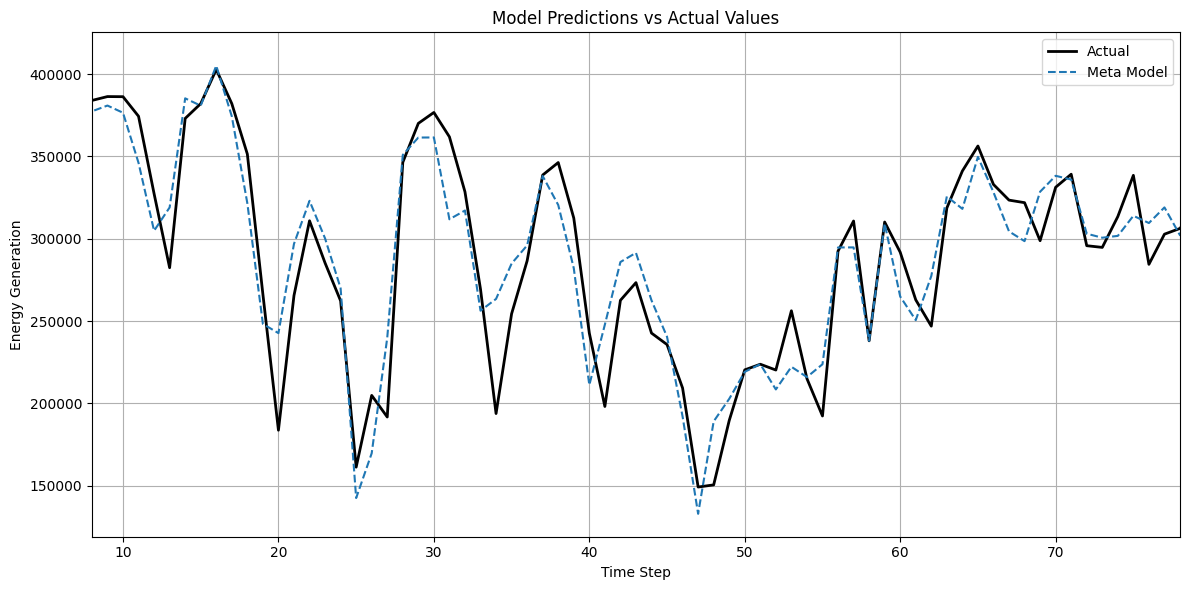

In [52]:
#Ploting data
# Garantir que as variáveis estejam com a forma correta
y_true = y_test_final.reshape(-1)
meta_pred = meta_pred.reshape(-1)

# Inverter a padronização (Z-Score -> valores reais)
y_true_orig = scalers['val_geracao'].inverse_transform(y_true.reshape(-1, 1)).flatten()
meta_pred_orig = scalers['val_geracao'].inverse_transform(meta_pred.reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)

# Ajuste de deslocamento temporal
lag_offset = 7
x_pred = range(lag_offset, lag_offset + len(meta_pred_orig))
plt.plot(x_pred, meta_pred_orig, label='Meta Model', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(8, 78)
plt.show()